In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import train_test_split function
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Import LabelEncoder
from sklearn import preprocessing


* **train.csv:** Este é o conjunto de treino que será utilizado para treinar o modelo. Para o treino serão utilizados os dados das eleições dos anos de 2006 e 2010;
* **test.csv:** Este é o conjunto de teste, usado para validar o modelo. Para isso, será usada uma parte dos dados das eleições de 2014;

Os dados utilizados correspondem aos das eleições de Deputado Federal nos anos de 2006, 2010 e 2014. Estão dividos nas seguintes colunas:

* **ano:** Ano da eleição;
* **sequencial_candidato:** O identificador do candidato. Corresponde à coluna Id do arquivo de submissão;
* **nome:** Nome do candidato;
* **uf:**  Sigla do estado do candidato;
* **partido:** Partido do candidato;
* **quantidade_doacoes:** Número de doações que um candidato recebeu;
* **quantidade_doadores:** Número de doadores que um candidato teve;
* **total_receita:** Total de receita de um candidato;
* **media_receita:** Média da receita de um candidato;
* **recursos_de_outros_candidatos.comites:** Total de receita proveniente de outros candidatos e comitês;
* **recursos_de_pessoas_fisicas:** Total de receita proveniente de pessoas físicas;
* **recursos_de_pessoas_juridicas:** Total de receita proveniente de pessoas juridicas;
* **recursos_proprios:** Total de receita proveniente dos próprios candidatos;
* **recursos_de_partido_politico:** Total de receita proveniente do partido do candidato;
* **quantidade_despesas:** Número de despesas que um candidato teve;
* **quantidade_fornecedores:** Número de fornecedores que um candidato teve;
* **total_despesa:** Total de depesa de um candidato;
* **media_despesa:** Média da despesa de um candidato;
* **cargo:** Cargo ao qual o candidato está concorrendo;
* **sexo:** Sexo do candidato;
* **grau:** Grau de escolaridade do candidato;
* **estado_civil:** Estado civil do candidato;
* **ocupacao:** Ocupação do candidato;
* **situacao:** Situação final do candidato. Corresponde à coluna Predict do arquivo de submissão;

In [173]:
train = pd.read_csv("data/train.csv").drop("nome", 1).drop("uf", 1).drop("media_receita", 1).drop("media_despesa", 1).drop("cargo", 1).drop("estado_civil", 1).drop("ocupacao", 1)


df_train = pd.DataFrame(train) # load the dataset as a pandas data frame
df_train.head(5)
#print("#Rows and #columns", df_train.shape)
#df_train.columns


,ano,sequencial_candidato,partido,quantidade_doacoes,quantidade_doadores,total_receita,recursos_de_outros_candidatos.comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,recursos_de_partido_politico,quantidade_despesas,quantidade_fornecedores,total_despesa,sexo,grau,situacao
0,2006,10001,PT,6,6,16600.00,0.0,9000.0,6300.00,1300.0,0.0,14,14,16583.60,MASCULINO,ENSINO MÉDIO COMPLETO,nao_eleito
1,2006,10002,PT,13,13,22826.00,6625.0,15000.0,1000.00,201.0,0.0,24,23,20325.99,FEMININO,SUPERIOR COMPLETO,nao_eleito
2,2006,10002,PT,17,16,158120.80,2250.0,34150.0,62220.80,59500.0,0.0,123,108,146011.70,FEMININO,SUPERIOR COMPLETO,eleito
3,2006,10002,PRONA,6,6,3001.12,0.0,1150.0,1101.12,750.0,0.0,8,8,3001.12,MASCULINO,ENSINO MÉDIO INCOMPLETO,nao_eleito
4,2006,10003,PT,48,48,119820.00,0.0,50878.0,0.00,68942.0,0.0,133,120,116416.64,MASCULINO,ENSINO FUNDAMENTAL COMPLETO,eleito


In [174]:
validation = pd.read_csv("data/test.csv").drop("nome", 1).drop("uf", 1).drop("media_receita", 1).drop("media_despesa", 1).drop("cargo", 1).drop("estado_civil", 1).drop("ocupacao", 1)

df_validation = pd.DataFrame(validation) # load the dataset as a pandas data frame

df_validation.head(5)
print("#Rows and #columns", df_validation.shape)
#df_validation.columns

#Rows and #columns (4592, 16)


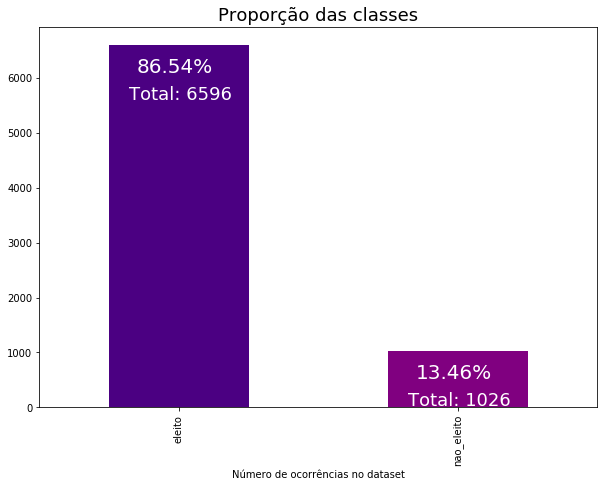

In [175]:
def plot_groups(df):
    ax = df['situacao'].value_counts().plot(kind='bar',
                                              figsize=(10,7),
                                              color=["indigo", "purple"], )

    ax.set_alpha(0.8)
    ax.set_title("Proporção das classes", fontsize=18)
    ax.set_xlabel("Número de ocorrências no dataset", fontsize=10);
    ax.set_xticklabels(["eleito", "nao_eleito"])

    # create a list to collect the plt.patches data
    totals = []

    # find the values and append to list
    for i in ax.patches:
        totals.append(i.get_height())

    # set individual bar lables using above list
    total = sum(totals)

    # set individual bar lables using above list
    for i in ax.patches:
        # get_x pulls left or right; get_height pushes up or down
        ax.text(i.get_x()+.1, i.get_height()-500, \
                str(round((i.get_height()/total)*100, 2))+'%', fontsize=20,
                    color='white')
        ax.text(i.get_x()+.07, i.get_height()-999, \
                "Total: " + str(i.get_height()), fontsize=18,
                    color='white')


plot_groups(df_train)

Como observado no gráfico acima, as classes estão desbalanceadas. Esse desbalanceamento pode tendenciar o classificador a classificar os dados como pertencentes à classe majoritária. Segundo Emerson L. M e Marcelo L. (MACHADO, Emerson Lopes. Um estudo de limpeza em base de dados desbalanceada e com sobreposiçao de classes. 2007.), classificadores gerados a partir de bases de treinamento desbalanceadas apresentam altas taxas de falsos negativos para as classes minoritárias. 

Existem basicamente duas formas de tratar o desbalanceamento de classes: 
* Atribuir custos diferenciados às classes durante a indução do modelo de classificação;
*  Reamostragem de dados (subamostragem ou sobreamostragem): Na **subamostragem**, dados da classe majoritária são removidos (desvantagem: se realizada de forma aleatória pode desprezar dados úteis), enquanto na **sobreamostragem**, dados da classe minoritária são replicados ou são gerados dados sintéticos (desvantagem:  a replicação dos exemplos tende a aumentar o custo computacional do processo).

## Reamostragem dos dados

(2052, 17)

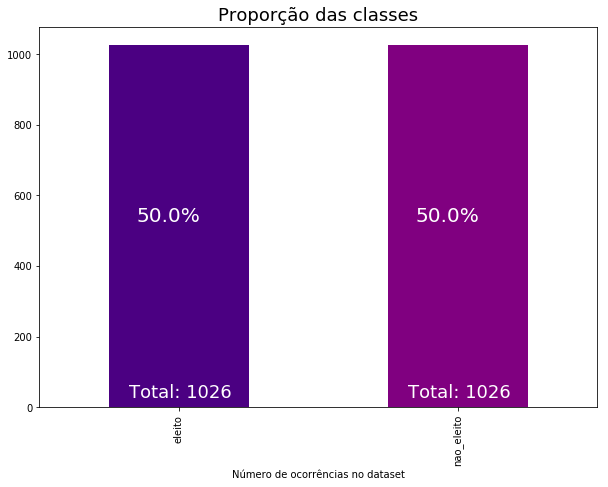

In [176]:
sample_size = 1026

elected = df_train[df_train["situacao"] == "eleito"]

not_elected = df_train[df_train["situacao"] == "nao_eleito"].sample(sample_size)

samples_array = []

samples_array.append(elected)
samples_array.append(not_elected)

df_train_balanced = pd.concat(samples_array)

plot_groups(df_train_balanced)
df_train_balanced.shape


**Treine: um modelo de regressão logística, KNN, uma árvore de decisão e um modelo de adaboost. Tune esses modelos usando validação cruzada e controle overfitting se necessário, considerando as particularidades de cada modelo.**

In [184]:
features = df_train_balanced.drop("situacao", 1)

# tranform categorical variables
features = pd.get_dummies(features)

# Split dataset into training set and test set
X_train, X_test, Y_train, Y_test = train_test_split(features, df_train_balanced["situacao"], test_size=0.3) # 70% training and 30% test

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(1436, 53)
(616, 53)
(1436,)
(616,)


The optimal number of neighbors is 10


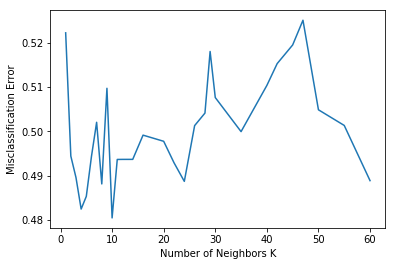

In [194]:

neighbors = [1,2,3,4,5,6,7,8,9,10,11,12,14,16,20,22,24,26,28,29,30,35,40,42,45,47,50,55,60]

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

In [193]:
knn_model = KNeighborsClassifier(n_neighbors=optimal_k)

knn_model.fit(X_train, Y_train)
knn_model.score(X_test, Y_test)


0.8392857142857143

Links e Referências:

* [BAR CHART ANNOTATIONS WITH PANDAS AND MATPLOTLIB](http://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html)

* [Um Estudo de Limpeza em Base de Dados Desbalanceada
com Sobreposição de Classes](https://www.cos.ufrj.br/~ines/enia07_html/pdf/28076.pdf)

* [Pré-processamento de dados](https://edisciplinas.usp.br/pluginfile.php/4052836/mod_resource/content/4/mineracaodadosbiologicos-parte3.pdf)
* [KNN Classification using Scikit-learn](https://www.datacamp.com/community/tutorials/k-nearest-neighbor-classification-scikit-learn)
* [A Complete Guide to K-Nearest-Neighbors with Applications in Python and R](https://kevinzakka.github.io/2016/07/13/k-nearest-neighbor/)